In [82]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [83]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Part 1 - Prepare SQLAlchemy 

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [ ]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)

# Part 2 - Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

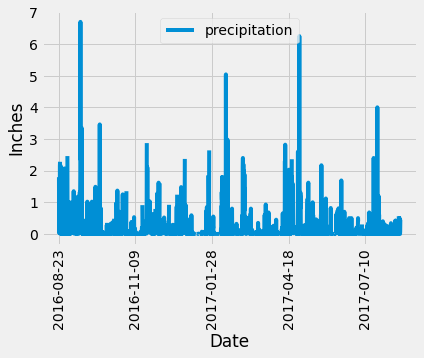

In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

latest_date = pd.read_sql('SELECT MAX(date) AS latest_date FROM measurement', conn)
latest_date

# Perform a query to retrieve the data and precipitation scores

recent_data = pd.read_sql('SELECT date, prcp AS precipitation FROM measurement WHERE date >= "2016-08-23"', conn)
recent_data.head()

# Save the query results as a Pandas DataFrame and set the index to the date column
recent_data_df = pd.DataFrame(recent_data).set_index('date')
recent_data_df.head()

# Sort the dataframe by date

sorted_recent_data_df = recent_data_df.sort_values('date')

prcp_plot = sorted_recent_data_df.plot(kind='line',rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')


In [94]:
# Use Pandas to calculate the summary statistics for the precipitation data

sorted_recent_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [96]:
# Design a query to show how many stations are available in this dataset?

query = '''
        SELECT
            COUNT(*) as station_count
        FROM
           station
        '''
distinct_stations = pd.read_sql(query, conn)
distinct_stations


,station_count
0,9


In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = '''
        SELECT
            station,
            COUNT(station) AS station_count
        FROM
            measurement
        GROUP BY
            station
        ORDER BY
            station_count DESC
        '''

station_counts = pd.read_sql(query, conn)
station_counts

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

query = '''
        SELECT
            MIN(tobs) AS lowest_temp,
            MAX(tobs) AS highest_temp,
            AVG(tobs) AS average_temp
        FROM
            measurement
        WHERE
            station = 'USC00519281'
            '''
temp_stats = pd.read_sql(query, conn)
temp_stats

,lowest_temp,highest_temp,average_temp
0,54.0,85.0,71.663781


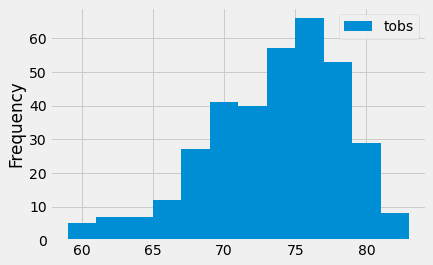

In [97]:
# Choose the station with the highest number of temperature observations.

query_1 = '''
        SELECT
            station,
            tobs
        FROM
            measurement
        WHERE
            date >= "2016-08-23"
            AND station = "USC00519281"
              '''
temp_counts = pd.read_sql(query_1, conn)
temp_counts
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_counts.plot.hist(bins=12)


## Part 3 - Data Analysis Assignment

In [103]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    query = f'''
        SELECT
            MIN(tobs) AS lowest_temp,
            MAX(tobs) AS highest_temp,
            AVG(tobs) AS average_temp
        FROM
            measurement
        WHERE
            date BETWEEN '{start_date}' AND '{end_date}'
            '''
    temp_stats = pd.read_sql(query, conn)
    return temp_stats

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


   lowest_temp  highest_temp  average_temp
0         62.0          74.0     69.571429


In [105]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
bday_trip = calc_temps('2017-07-08', '2017-07-15')
print(bday_trip)


   lowest_temp  highest_temp  average_temp
0         69.0          82.0     78.307692


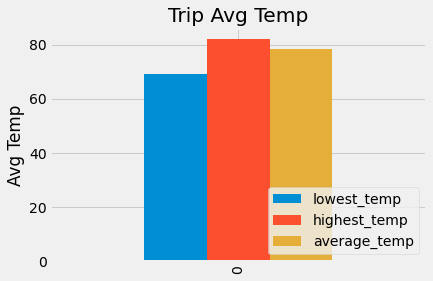

In [116]:
# Plot the results from your previous query as a bar chart. 


bday_trip.plot(kind='bar')
plt.title('Trip Avg Temp')
plt.ylabel('Avg Temp')
plt.legend(loc='lower right')

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [132]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query = '''
        SELECT
            station,
            SUM(prcp) AS total_rainfall,
            date
        FROM
            measurement
        WHERE
            date >= "2017-07-08" AND date <= "2017-07-15" 
        GROUP BY
            station
        ORDER BY
            date
        '''
trip_rainfall = pd.read_sql(query, conn)
trip_rainfall

,station,total_rainfall,date
0,USC00513117,0.54,2017-07-08
1,USC00514830,0.39,2017-07-08
2,USC00516128,1.55,2017-07-08
3,USC00519281,1.00,2017-07-08
4,USC00519397,0.09,2017-07-08
5,USC00519523,0.11,2017-07-08
6,USC00517948,NaN,2017-07-10


In [138]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    
    query = f'''
            SELECT
                MIN(tobs) AS tmin,
                MAX(tobs) AS tmax,
                AVG(tobs) AS tavg,
                date
            FROM
                measurement
            WHERE
                DATE(date) = '{date}'
            GROUP BY
                date
            '''
    trip_temps = pd.read_sql(query, conn)

    return trip_temps
    
daily_normals("01-01")

,tmin,tmax,tavg,date


In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
